<a href="https://colab.research.google.com/github/viviennejuma/NaiveBayes-x-KNN/blob/main/Titanic_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading libraries 
Importing Pandas, Numpy, Matplotlib and some Scikit-learn algorithms and functions.

In [ ]:
# Pandas - Data manipulation and analysis library
import pandas as pd

# NumPy - mathematical functions on multi-dimensional arrays and matrices
import numpy as np
import seaborn as sns
# Matplotlib - plotting library to create graphs and charts
import matplotlib.pyplot as plt

# Scikit-learn algorithms and functions
from sklearn.neighbors import KNeighborsClassifier # Scikit-learn KNeighbors Classifier
from sklearn.tree import DecisionTreeClassifier # Scikit-learn Decision Tree Classifier
from sklearn.model_selection import KFold # Scikit-learn K-Folds cross-validator
from sklearn.model_selection import cross_val_score # evaluating cross-validator performance
k_fold = KFold(n_splits=10, shuffle=True, random_state=0) # KFold configuration

# Settings for Matplotlib graphs and charts
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

# Display Matplotlib output inline
%matplotlib inline

In [ ]:

train = pd.read_csv("https://archive.org/download/train5_202002/train%20%285%29.csv")
test = pd.read_csv("https://archive.org/download/test1_202002/test%20%281%29.csv")

# EDA

In [ ]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
train.shape

(891, 12)

In [ ]:
test.shape

(418, 11)


The only difference with the test data set is the number of records which is 418 and the number of columns which is 11. We are missing the Survived column in the test data set. We will be predicting the Survived column with the machine learning model we are going to build.

In [ ]:
891 -418

473

In [ ]:
print('There are ' + str(len(train)+len(test)) + ' passengers in both data sets.')
print(str(len(train)) + ' in train data set.')
print(str(len(test)) + ' in train data set.')

There are 1309 passengers in both data sets.
891 in train data set.
418 in train data set.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [ ]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [ ]:

def showChart(feature):
    survived = train[train['Survived']==1][feature].value_counts()
    dead = train[train['Survived']==0][feature].value_counts()
    df = pd.DataFrame([survived, dead])
    df.index = ['Survived', 'Dead']
    df.plot(kind='bar', stacked=True, figsize=(12,8))

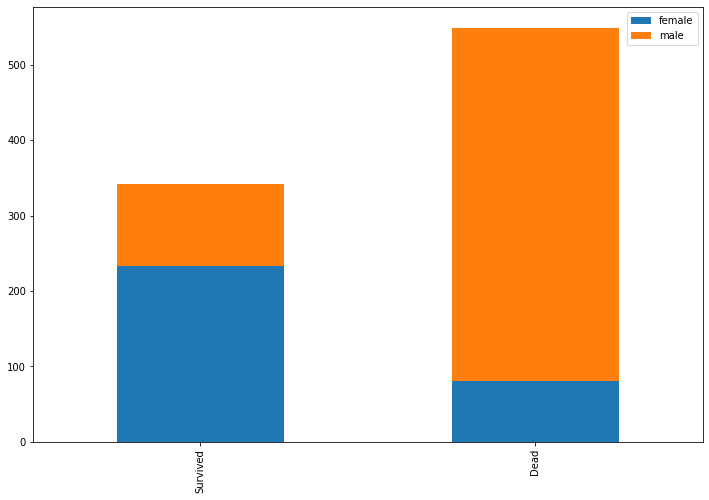

In [ ]:
showChart('Sex')


We can see that significantly more females survived than males. We have even more significant results for passengers that did not survived where females make a very small percentage in comparison to males.

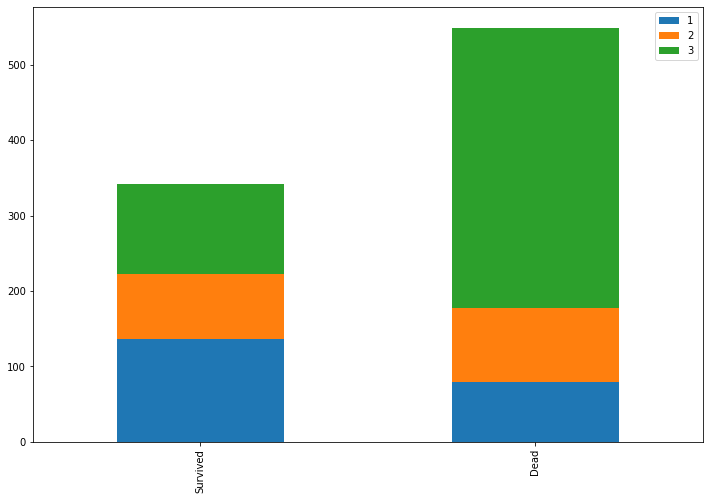

In [ ]:
# Passengers
showChart('Pclass')

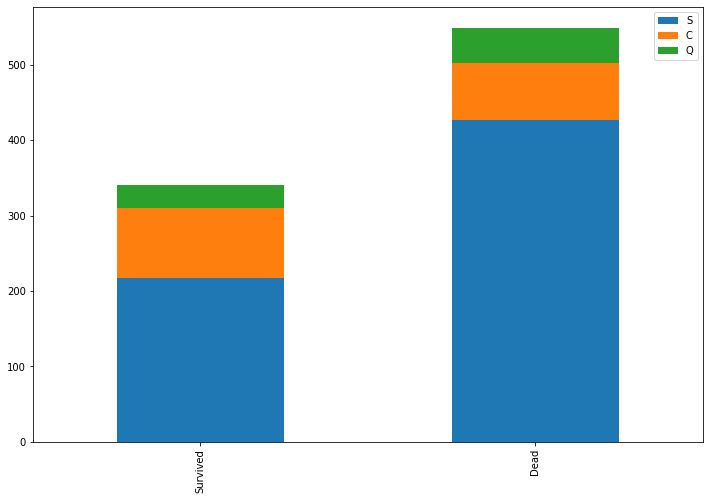

In [ ]:
showChart('Embarked')

# Feature Engineering

In [ ]:
# Replace missing value with the median value for the column
#We have many missing values in the Age column.
# We will fill all the missing values in the Age column with the median values for that column. 
#Median value is "the middle" value for the columns. To make the values more accurate we will calculate the median value for each Sex separately. 
#We will also perform this for both train and test data set.

In [ ]:
train["Age"].fillna(train.groupby('Sex')['Age'].transform("median"), inplace=True)
test["Age"].fillna(test.groupby('Sex')['Age'].transform("median"), inplace=True)

In [ ]:
# We are going to put the passengers to four age groups:
#1: (age <= 18)
#2: (age > 18 and <= 40)
#3: (age > 40 and <= 60)
#4: (age > 60)
#We will perform this for train and test data.

In [ ]:

train.loc[train['Age'] <= 18, 'Age'] = 1
train.loc[(train['Age'] > 18) & (train['Age'] <= 40), 'Age'] = 2
train.loc[(train['Age'] > 40) & (train['Age'] <= 60), 'Age'] = 3
train.loc[train['Age'] > 60, 'Age'] = 4

In [ ]:
test.loc[test['Age'] <= 18, 'Age'] = 1
test.loc[(test['Age'] > 18) & (test['Age'] <= 40), 'Age'] = 2
test.loc[(test['Age'] > 40) & (test['Age'] <= 60), 'Age'] = 3
test.loc[train['Age'] > 60, 'Age'] = 4

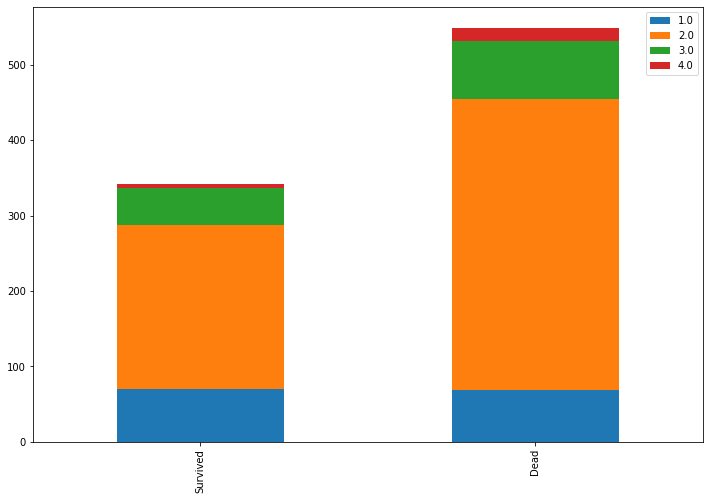

In [ ]:
showChart('Age')

In [ ]:
# mapping the sex column

sex_mapping_values = {"male": 0, "female": 1}

train.replace({'Sex':sex_mapping_values}, inplace=True)
test.replace({'Sex':sex_mapping_values}, inplace=True)

In [ ]:
#One other thing that would be useful to do is to extract Title information like (Mr. Mrs. Miss.) from the Name column and create bins
#similar to what we have done with the Age column and after that drop the Name column.

In [ ]:
train['Title'] = train['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test['Title'] = test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [ ]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Lady          1
Ms            1
Countess      1
Mme           1
Jonkheer      1
Capt          1
Sir           1
Don           1
Name: Title, dtype: int64

In [ ]:
test['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dona        1
Ms          1
Dr          1
Name: Title, dtype: int64

In [ ]:
# As we can see we only really have 3 major groups here, Mr, Miss and Mrs. 
# We will create four bins here with these groups and put everything else into the Other category. 
# Our groups are going to look like this:
#1: Mr
#2: Miss
#3: Mrs
#4: everything else

In [ ]:
title_mapping_values = {"Mr": 0, "Miss": 1, "Mrs": 2, "Master": 3, "Dr": 3, "Rev": 3, "Col": 3, "Major": 3, "Mlle": 3, "Sir": 3, "Mme": 3, "Ms": 3, "Countess": 3, "Capt": 3, "Don": 3, "Dona": 3, "Jonkheer": 3, "Lady": 3}

train.replace({'Title':title_mapping_values}, inplace=True)
test.replace({'Title':title_mapping_values}, inplace=True)

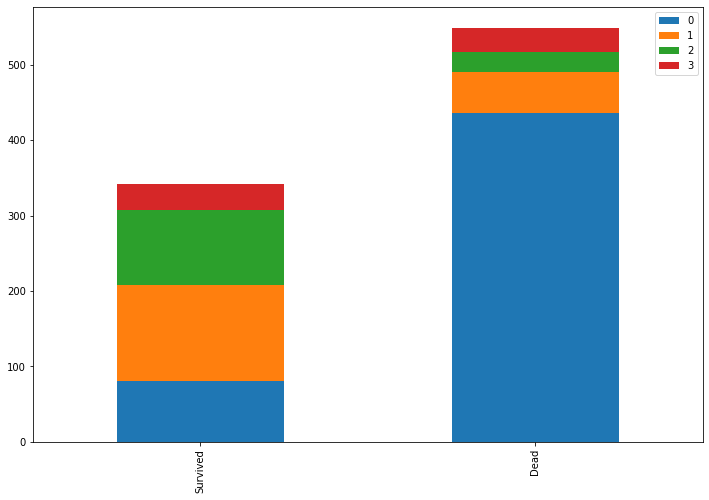

In [ ]:
showChart('Title')

In [ ]:
features = ['Name', 'Ticket', 'Fare', 'Cabin', 'Embarked']
train = train.drop(features, axis=1)
test = test.drop(features, axis=1)
train = train.drop(['PassengerId'], axis=1)

In [ ]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Title
0,0,3,0,2.0,1,0,0
1,1,1,1,2.0,1,0,2
2,1,3,1,2.0,0,0,1
3,1,1,1,2.0,1,0,2
4,0,3,0,2.0,0,0,0


In [ ]:
train_data = train.drop('Survived', axis=1)
target = train['Survived']

In [ ]:
# Building ad training our model

# K-nearest neighbors (KNN) classifier

In [ ]:
clf = KNeighborsClassifier(n_neighbors = 13)
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.82222222 0.76404494 0.82022472 0.79775281 0.80898876 0.83146067
 0.82022472 0.79775281 0.82022472 0.84269663]


In [ ]:
scoreP = round(np.mean(score)*100, 2)
print('Our KNN classifier score is ' + str(scoreP) + '%')

Our KNN classifier score is 81.26%


In [ ]:

clf = KNeighborsClassifier()
clf.fit(train_data, target)

test_data = test.drop("PassengerId", axis=1).copy()
prediction = clf.predict(test_data)

In [ ]:
prediction

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,

## Challenging the solution with Decision trees

In [ ]:
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score = cross_val_score(clf, train_data, target, cv=k_fold, n_jobs=1, scoring=scoring)
print(score)

[0.8        0.79775281 0.78651685 0.78651685 0.86516854 0.78651685
 0.84269663 0.80898876 0.78651685 0.84269663]


In [ ]:
scoreP = round(np.mean(score)*100, 2)
print('Our Decision Tree classifier score is ' + str(scoreP) + '%')

Our Decision Tree classifier score is 81.03%


The accuracy is more or less the same
